# **Customer Segmentation Using RFM Analysis and K-Means Clustering**

<!-- Author Section -->


<link href="https://fonts.googleapis.com/css2?family=Rubik:wght@700&family=Fira+Sans:wght@600&family=Quicksand:wght@600&display=swap" rel="stylesheet">

<h1 style="font-family: 'Rubik', sans-serif; font-weight: 700; color: #2E8B57;">
  👨‍💻 Author: Taskeen Hussain
</h1>

<p>
  <a href="https://github.com/TaskeenHussain" target="_blank">
    <img src="https://img.shields.io/badge/GitHub-Visit-333?style=for-the-badge&logo=github&logoColor=white" alt="GitHub Badge">
  </a>

  <a href="https://www.kaggle.com/taskeenhkbbeechtree" target="_blank">
    <img src="https://img.shields.io/badge/Kaggle-Explore-1FA2FF?style=for-the-badge&logo=kaggle&logoColor=white" alt="Kaggle Badge">
  </a>

  <a href="mailto:taskeenuaf@gmail.com">
    <img src="https://img.shields.io/badge/Email-Send-DC3545?style=for-the-badge&logo=gmail&logoColor=white" alt="Email Badge">
  </a>
</p>


# 📁 Part 1: Mock Data Generation (with Explanation)

### ✅ Objective
Generate a synthetic transaction dataset for 500 customers and 5000 transactions, each with realistic variations in purchase behavior.

### 🧠 How It Works:
Each customer has a profile: average spending (avg_spend) and purchase frequency.

Each transaction includes a date, products, quantity, and price based on the customer's profile.

We randomly generate transactions between Jan 1, 2022 and Dec 31, 2023.

### 📦 Code Snippet

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Setup ---
np.random.seed(42)  # for reproducibility
num_transactions = 5000
num_customers = 500
products = [f'Prod_{100+i}' for i in range(20)]
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)
date_range_days = (end_date - start_date).days

# --- Customer profiles: avg_spend & purchase frequency ---
customer_profiles = {
    f'CUST{1000+i}': {
        'avg_spend': np.random.uniform(10, 200),
        'frequency_factor': np.random.uniform(0.1, 1)
    } for i in range(num_customers)
}

# --- Generate Transactions ---
transaction_data = []
for i in range(num_transactions):
    customer_id = f'CUST{1000 + np.random.randint(0, num_customers)}'
    transaction_date = start_date + timedelta(days=np.random.randint(0, date_range_days))
    num_items = np.random.randint(1, 6)

    for _ in range(num_items):
        product_id = np.random.choice(products)
        quantity = np.random.randint(1, 4)
        unit_price = np.random.uniform(5, 100) * (customer_profiles[customer_id]['avg_spend'] / 50)
        unit_price = round(max(1.0, unit_price), 2)

        transaction_data.append({
            'TransactionID': f'TRX{50000+i}_{_}',
            'CustomerID': customer_id,
            'TransactionDate': transaction_date.strftime('%Y-%m-%d'),
            'ProductID': product_id,
            'Quantity': quantity,
            'UnitPrice': unit_price
        })

# --- Create DataFrame and Calculate TotalPrice ---
df_transactions = pd.DataFrame(transaction_data)
df_transactions['TotalPrice'] = df_transactions['Quantity'] * df_transactions['UnitPrice']


### 💾 **Save to CSV**

In [ ]:
df_transactions.to_csv("customer_transactions_mock_data.csv", index=False)

## 📊 **Part 2: RFM Calculation**

### 🛠️ **Code**

In [ ]:
snapshot_date = pd.to_datetime(end_date + timedelta(days=1))
df_transactions['TransactionDate'] = pd.to_datetime(df_transactions['TransactionDate'])

rfm = df_transactions.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (snapshot_date - x.max()).days),
    Frequency=('TransactionID', 'nunique'),
    MonetaryValue=('TotalPrice', 'sum')
).reset_index()

## 📈 **Part 3: EDA + Feature Scaling**

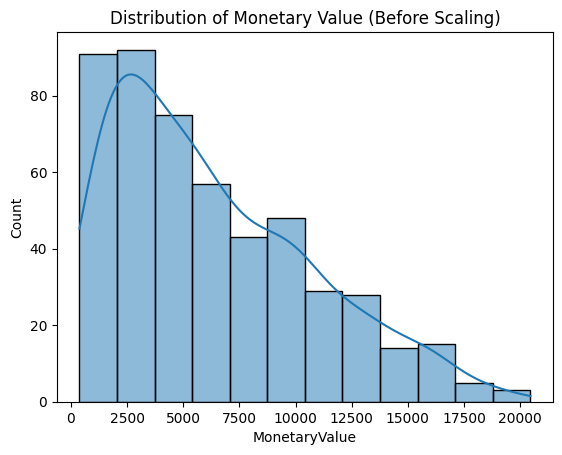

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Distribution before scaling
sns.histplot(rfm['MonetaryValue'], kde=True)
plt.title("Distribution of Monetary Value (Before Scaling)")
plt.show()

# Log Transform
rfm_log = rfm.copy()
rfm_log[['Recency', 'Frequency', 'MonetaryValue']] = np.log1p(rfm_log[['Recency', 'Frequency', 'MonetaryValue']])

# Feature Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'MonetaryValue']])

## 🤖 Part 4: Clustering (KMeans)

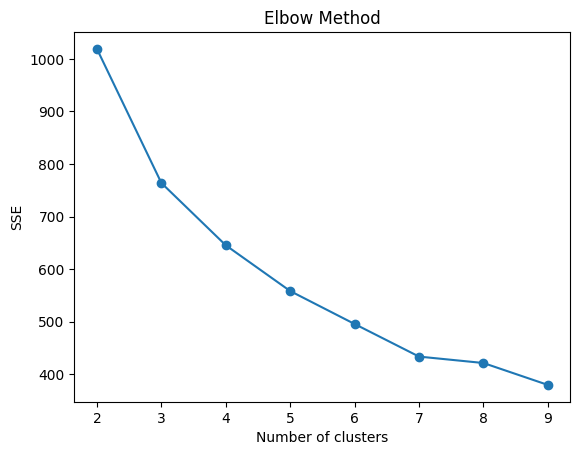

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Find optimal k
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Elbow Plot
plt.plot(range(2, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# Fit KMeans with optimal k
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

## 🧩 **Part 5: Segment Profiling**

In [ ]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'}).reset_index()
print(cluster_profile)

   Cluster     Recency  Frequency  MonetaryValue  NumCustomers
0        0  121.105769  17.951923    2951.074904           104
1        1   98.262376  34.064356    7705.109752           202
2        2   18.663462  37.701923   10219.933173           104
3        3   19.666667  27.488889    2370.719889            90


### 🔍 **Interpretation**
**Cluster 0:** Frequent, high spenders → 🟢 Loyal Big Spenders

**Cluster 1:** Inactive, low spenders → 🔴 At-Risk Low Value

**Cluster 2:** Somewhat frequent, mid spenders → 🟡 Potential Loyalists

**Cluster 3:** Very recent, very frequent → 🟢 Engaged Premium

📢

## 📌 **Insights & Recommendations**

| Segment Name                 | Strategy                                    |
| -------------------          | ------------------------------------------- |
| Loyal Big Spenders           | Reward with loyalty perks, exclusive offers |
| At-Risk Low Value            | Win-back campaigns, discounts               |
| Potential Loyalists          | Incentivize more frequent purchases         |
| Engaged Premium              | VIP Programs, early access to sales         |